In [1]:
#data tools
from src import prepare_europe_data, prepare_empty_frame, plot_covid_data, get_daily_cases, tukey_outliers, crosscorr
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
import itertools

#linear algebra/ math
import numpy as np 
from math import sqrt

#plots
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pandas.plotting import lag_plot
from fbprophet.plot import add_changepoints_to_plot
plt.style.use('seaborn')

#metrics
from sklearn.metrics import mean_squared_error

#statistical tools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import ccf
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from scipy.stats import pearsonr
from scipy.stats import shapiro
from scipy import stats

#models
from fbprophet import Prophet
from statsmodels.tsa.arima_model import ARIMA

In [19]:
data_path = '../../data/raw/time_series_covid19_confirmed_global.csv'
data_raw = pd.read_csv(data_path)
data_prepared_poland = prepare_europe_data(data=data_raw, start_date='4/1/20', end_date='5/27/20', country='Poland')
df = data_prepared_poland

In [20]:
plot_covid_data(data=data_prepared_poland, country='Poland')

In [21]:
df, daily_growth_series = get_daily_cases(df)

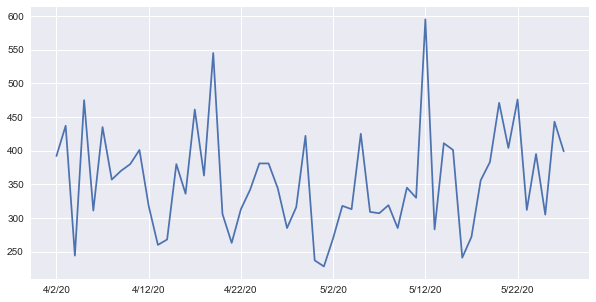

In [22]:
plt.figure(figsize=(10,5))
daily_growth_series.plot()

In [23]:
#google trends data preparation
data_path_objawy = '../../data/raw/multiTimeline_objawy_4-6_20.csv'
data_trends_objawy = pd.read_csv(data_path_objawy, header=1)
columns = data_trends_objawy.columns
columns = [x.split()[0].lower().replace(":","") for x in columns]
data_trends_objawy.columns = columns
data_trends_objawy = data_trends_objawy.rename(columns={"dzień": "date"})
data_trends_objawy

,date,objawy
0,2020-04-01,53
1,2020-04-02,27
2,2020-04-03,97
3,2020-04-04,50
4,2020-04-05,62
...,...,...
86,2020-06-26,16
87,2020-06-27,20
88,2020-06-28,69
89,2020-06-29,44


In [24]:
data_trends_objawy.loc[56]

date      2020-05-27
objawy            43
Name: 56, dtype: object

In [92]:
data_trends_objawy_0603 = data_trends_objawy.iloc[:56+7]

In [93]:
data_trends_objawy_0603_w_shift = data_trends_objawy_0603.shift(-7).dropna()

In [94]:
df_daily = pd.DataFrame(daily_growth_series)
df_daily['ds'] = df_daily.index
df_daily = df_daily.rename(columns = {'DailyGrowthCases':'y'})
df_daily = df_daily.reset_index()
del df_daily['index']
df_daily = df_daily[['ds', 'y']]
df_daily.ds = pd.to_datetime(df_daily.ds)

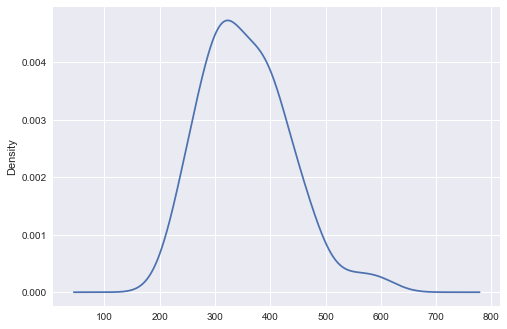

In [28]:
daily_growth_series.plot.kde()

In [95]:
daily_float = daily_growth_series.values.astype('float64')
daily_boxcoxed, lam_1 = boxcox(daily_float)
daily_boxcoxed_series = pd.Series(daily_boxcoxed)
daily_boxcoxed_series.plot.kde()

In [34]:
stat, p = shapiro(daily_boxcoxed)
stat, p

(0.9882268905639648, 0.8591538071632385)

In [99]:
df_daily['y'] = daily_boxcoxed

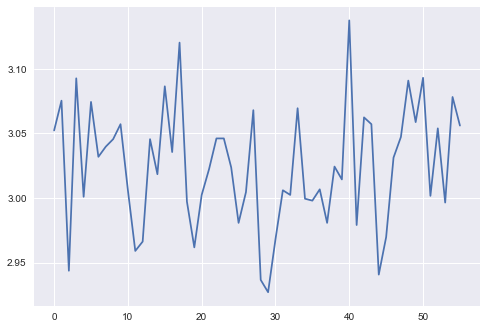

In [92]:
plt.plot(daily_boxcoxed)

Facebook Prophet with regressor

In [12]:
#https://nbviewer.jupyter.org/github/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb

SyntaxError: invalid syntax (<ipython-input-12-cae7463e38ec>, line 1)

In [100]:
trends_shift_plus1 = data_trends_objawy_0603_w_shift.objawy.values + 1
trends_boxcoxed, lam_2 = boxcox(trends_shift_plus1)

In [102]:
df_daily['objawy'] = trends_boxcoxed

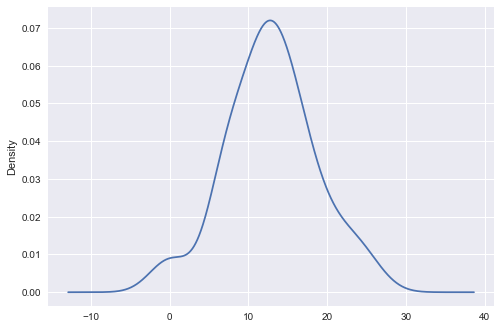

In [103]:
pd.Series(trends_boxcoxed).plot.kde()

In [104]:
stat, p = shapiro(trends_boxcoxed)
stat, p

(0.9729830026626587, 0.2398611605167389)

In [105]:
m = Prophet(changepoint_range=0.3, changepoint_prior_scale=0.00001)
m.add_regressor('objawy', prior_scale=0.35, mode='multiplicative')
m.fit(df_daily)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


In [106]:
data_trends_objawy_future = data_trends_objawy.iloc[:63] #+7

In [107]:
future = m.make_future_dataframe(periods=7)
future['objawy'] = data_trends_objawy_future.objawy.values
future.tail()

,ds,objawy
58,2020-05-30,46
59,2020-05-31,18
60,2020-06-01,32
61,2020-06-02,29
62,2020-06-03,28


In [108]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
58,2020-05-30,2.936447,2.874737,3.000197
59,2020-05-31,3.022668,2.961261,3.083445
60,2020-06-01,2.941548,2.883470,3.006389
61,2020-06-02,3.031497,2.975658,3.086431
62,2020-06-03,3.014222,2.956269,3.075591


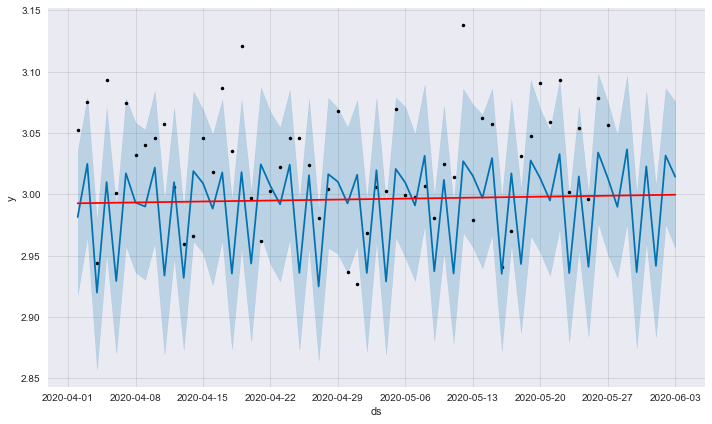

In [109]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

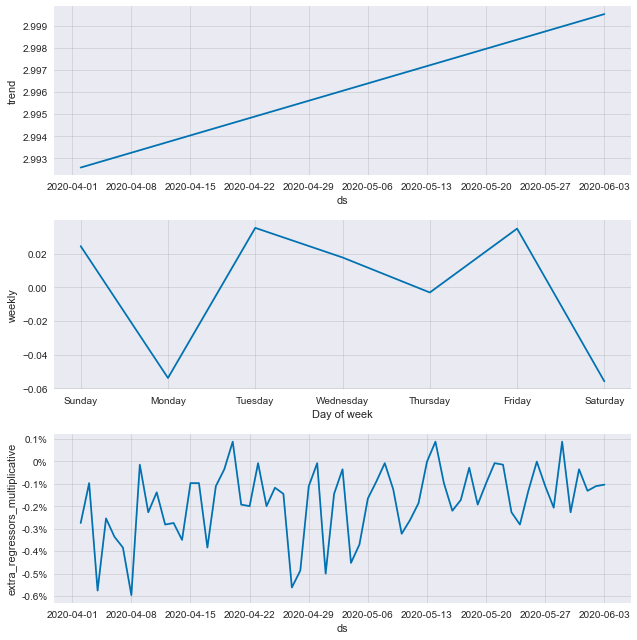

In [110]:
fig2 = m.plot_components(forecast)

In [112]:
next_week = inv_boxcox(forecast[-7:]['yhat'], lam_1).sum()
next_week

2168.1399982801217

In [116]:
poland_gt = prepare_europe_data(data=data_raw, start_date='5/27/20', end_date='6/3/20', country='Poland')
gt_total = poland_gt['6/3/20'].values[0]
gt_total

24687

In [117]:
predicted_total = next_week + poland_gt['5/27/20'].values[0]
predicted_total

24641.139998280123

In [118]:
gt_total - predicted_total

45.86000171987689